# Project 2

## Process
* create a small data set (only 12 elements) to look at text processing and see how BoW vectorization works
* create vectors for the data
    * default
    * exclude common words
    * exclude rare words
    * count # of times word is used in single review? or just present at all
    * look at word pairs? word triples? expensive to generate, could produce better results
* train a simple logistic regression on the data
    * look at all different vectors, see which set is best
* tweak logistic hyperparams
* train MLP
* train decision tree

In [37]:
# imports

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import minmax_scale

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

## Data processing
* Removing whitespace and punctuation
* Converting to all lowercase
* Generating vectors

### Default BoW

In [2]:
# big
raw_reviews = pd.read_csv('data/data_reviews/x_train.csv')['text'].values.tolist()
reviews = list()

pattern = re.compile('[^a-z ]')
for review in raw_reviews:
    review = review.lower()
    review = pattern.sub('', review)
    reviews.append(review)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reviews)
y = pd.read_csv('data/data_reviews/y_train.csv').to_numpy().ravel()

In [3]:
# # small
# raw_reviews_short = pd.read_csv('data/data_reviews/x_train_small.csv')['text'].values.tolist()
# reviews_short = list()

# pattern = re.compile('[^a-z ]')
# for review_short in raw_reviews_short:
#     review_short = review_short.lower()
#     review_short = pattern.sub('', review_short)
#     reviews_short.append(review_short)

# vectorizer_short = CountVectorizer()
# X_short = vectorizer_short.fit_transform(reviews_short)
# y_short = pd.read_csv('data/data_reviews/y_train_small.csv').to_numpy().ravel()
# # vectorizer_short.get_feature_names()

### BOW w 

## Logistic regression

### Default

In [4]:
# kf = KFold()
# log_model = linear_model.LogisticRegression()

# k_train_losses = list()
# k_train_scores = list()
# k_train_aucs = list()

# k_val_losses = list()
# k_val_scores = list()
# k_val_aucs = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_model.fit(x_train, y_train)
    
#     train_probas = minmax_scale(log_model.decision_function(x_train).reshape(-1,1))
#     val_probas = minmax_scale(log_model.decision_function(x_val).reshape(-1, 1))
#     # for i in train_probas:
#     #     print(i, end=' ') 
#     # print()
#     k_train_losses.append(log_loss(y_train, train_probas))
#     k_train_scores.append(log_model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
    
#     k_val_losses.append(log_loss(y_val, val_probas))
#     k_val_scores.append(log_model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
    
#     print('   TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#         k_train_aucs[-1],
#         k_train_losses[-1],
#         k_train_scores[-1]))

#     print('   TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#         k_val_aucs[-1],
#         k_val_losses[-1],
#         k_val_scores[-1]))

# print('TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_train_aucs),
#     np.mean(k_train_losses),
#     np.mean(k_train_scores)))

# print('TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_val_aucs),
#     np.mean(k_val_losses),
#     np.mean(k_val_scores)))

### Max iters

In [5]:
# # find max_iter
# train_losses = list()
# train_scores = list()
# val_scores = list()
# val_losses = list()

# for i in np.logspace(0, 2, 20):
#     kf = KFold()
#     log_model = linear_model.LogisticRegression(max_iter=i)

#     k_train_losses = list()
#     k_train_scores = list()
#     k_val_losses   = list()
#     k_val_scores   = list()

#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         log_model.fit(x_train, y_train)
#         k_train_losses.append(logloss(x_train, y_train, log_model))
#         k_train_scores.append(score(x_train, y_train, log_model))
#         k_val_losses .append(logloss(x_val, y_val, log_model))
#         k_val_scores .append(score(x_val, y_val, log_model))

#     train_losses.append(np.mean(k_train_losses))
#     train_scores.append(np.mean(k_train_scores))
#     val_losses.append(np.mean(k_val_losses))
#     val_scores.append(np.mean(k_val_scores))

# # plot accuracy
# plt.title('Model Accuracy vs Maximum Iterations')
# plt.xlabel('maximum iterations')
# plt.ylabel('accuracy')
# plt.scatter(np.logspace(0, 2, 20), val_scores)
# plt.show()

# # plot error
# plt.title('Logistic Loss vs Maximum Iterations')
# plt.xlabel('maximum iterations')
# plt.ylabel('logistic loss')
# plt.scatter(np.logspace(0, 2, 20), val_losses, c='r')
# plt.show()

### LBFGS L2
best C: 8.68511373751352

In [6]:
# # find best C
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_c = 10**-2
# best_loss = 1000

# kf = KFold(shuffle=True)
# for c in np.logspace(-2, 2, 50):
#     log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=c)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         log_model.fit(x_train, y_train)
        
#         train_probas = minmax_scale(log_model.decision_function(x_train))
#         val_probas = minmax_scale(log_model.decision_function(x_val))
                
#         k_train_scores.append(log_model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(log_model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_c = c
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         c,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best C:', best_c)

In [7]:
# # plots

# # plot accuracy
# plt.title('Model Accuracy vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('accuracy')
# plt.scatter(np.logspace(-2, 2, 50), val_scores, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_scores, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

# # plot loss
# plt.title('Logistic Loss vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('logistic loss')
# plt.scatter(np.logspace(-2, 2, 50), val_losses, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_losses, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

# # plot auc
# plt.title('AUC of ROC Curve vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('auc')
# plt.scatter(np.logspace(-2, 2, 50), val_aucs, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_aucs, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [8]:
# # best model details

# kf = KFold()
# log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=c)

# k_train_scores = list()
# k_train_aucs = list()
# k_train_losses = list()

# k_val_scores = list()
# k_val_aucs = list()
# k_val_losses = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_model.fit(x_train, y_train)

#     train_probas = minmax_scale(log_model.decision_function(x_train))
#     val_probas = minmax_scale(log_model.decision_function(x_val))
            
#     k_train_scores.append(log_model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

#     k_val_scores.append(log_model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

# print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_train_scores), 
#         np.mean(k_train_aucs),
#         np.mean(k_train_losses)))

# print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

### LBFGS none

In [9]:
# # details

# kf = KFold()
# log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='none', max_iter=500)

# k_train_scores = list()
# k_train_aucs = list()
# k_train_losses = list()

# k_val_scores = list()
# k_val_aucs = list()
# k_val_losses = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_model.fit(x_train, y_train)

#     train_probas = minmax_scale(log_model.decision_function(x_train))
#     val_probas = minmax_scale(log_model.decision_function(x_val))
            
#     k_train_scores.append(log_model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

#     k_val_scores.append(log_model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

# print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_train_scores), 
#         np.mean(k_train_aucs),
#         np.mean(k_train_losses)))

# print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

### liblinear L2
best C: 

In [10]:
# # find best C
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_c = 10**-2
# best_loss = 1000

# kf = KFold(shuffle=True)
# for c in np.logspace(-2, 2, 50):
#     log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l2', max_iter=500, C=c)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         log_model.fit(x_train, y_train)
        
#         train_probas = minmax_scale(log_model.decision_function(x_train))
#         val_probas = minmax_scale(log_model.decision_function(x_val))
                
#         k_train_scores.append(log_model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(log_model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_c = c
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         c,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best C:', best_c)

In [11]:
# # plots

# # plot accuracy
# plt.title('Model Accuracy vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('accuracy')
# plt.scatter(np.logspace(-2, 2, 50), val_scores, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_scores, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

# # plot loss
# plt.title('Logistic Loss vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('logistic loss')
# plt.scatter(np.logspace(-2, 2, 50), val_losses, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_losses, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

# # plot auc
# plt.title('AUC of ROC Curve vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('auc')
# plt.scatter(np.logspace(-2, 2, 50), val_aucs, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_aucs, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [12]:
# # best model details

# kf = KFold()
# log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l2', max_iter=500, C=c)

# k_train_scores = list()
# k_train_aucs = list()
# k_train_losses = list()

# k_val_scores = list()
# k_val_aucs = list()
# k_val_losses = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_model.fit(x_train, y_train)

#     train_probas = minmax_scale(log_model.decision_function(x_train))
#     val_probas = minmax_scale(log_model.decision_function(x_val))
            
#     k_train_scores.append(log_model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

#     k_val_scores.append(log_model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

# print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_train_scores), 
#         np.mean(k_train_aucs),
#         np.mean(k_train_losses)))

# print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

### liblinear L1
best C: 8.68511373751352

In [13]:
# # find best C
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_c = 10**-2
# best_loss = 1000

# kf = KFold(shuffle=True)
# for c in np.logspace(-2, 2, 50):
#     log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', max_iter=500, C=c)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         log_model.fit(x_train, y_train)
        
#         train_probas = minmax_scale(log_model.decision_function(x_train))
#         val_probas = minmax_scale(log_model.decision_function(x_val))
                
#         k_train_scores.append(log_model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(log_model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_c = c
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         c,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best C:', best_c)

In [14]:
# # plots

# # plot accuracy
# plt.title('Model Accuracy vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('accuracy')
# plt.scatter(np.logspace(-2, 2, 50), val_scores, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_scores, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

# # plot loss
# plt.title('Logistic Loss vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('logistic loss')
# plt.scatter(np.logspace(-2, 2, 50), val_losses, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_losses, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

# # plot auc
# plt.title('AUC of ROC Curve vs Inverse of Regularization Penalty')
# plt.xlabel('inverse of regularization penalty, C')
# plt.ylabel('auc')
# plt.scatter(np.logspace(-2, 2, 50), val_aucs, label='validation')
# plt.scatter(np.logspace(-2, 2, 50), train_aucs, c='r', label='train')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [15]:
# # best model details

# kf = KFold()
# log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', max_iter=500, C=c)

# k_train_scores = list()
# k_train_aucs = list()
# k_train_losses = list()

# k_val_scores = list()
# k_val_aucs = list()
# k_val_losses = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_model.fit(x_train, y_train)

#     train_probas = minmax_scale(log_model.decision_function(x_train))
#     val_probas = minmax_scale(log_model.decision_function(x_val))
            
#     k_train_scores.append(log_model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

#     k_val_scores.append(log_model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

# print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_train_scores), 
#         np.mean(k_train_aucs),
#         np.mean(k_train_losses)))

# print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

## MLP

In [50]:
# random grid search best model
# generally, lower alpha and lower tolerance work best, with only small changes between solver and activation
parameters = {
    'solver': ['adam', 'lbfgs'],
    'activation': ['relu', 'identity'],
    'alpha': list(np.logspace(-3, 3, 25)),
    'tol': [10**i for i in range(-8, 3, 1)]
}

mlp = RandomizedSearchCV(MLPClassifier(), parameters, n_iter=50)
mlp.fit(X, y)

pd.DataFrame(mlp.cv_results_)

C:\Users\lexis\miniconda3\envs\ml_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\lexis\miniconda3\envs\ml_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\lexis\miniconda3\envs\ml_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to conv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_solver,param_alpha,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.773048,0.240800,0.002393,0.001010,100,lbfgs,562.341325,identity,"{'tol': 100, 'solver': 'lbfgs', 'alpha': 562.3...",0.493750,0.497917,0.504167,0.475000,0.497917,0.493750,0.009948,10
1,3.319957,0.400572,0.001400,0.001354,0.001,lbfgs,0.017783,identity,"{'tol': 0.001, 'solver': 'lbfgs', 'alpha': 0.0...",0.827083,0.802083,0.747917,0.764583,0.806250,0.789583,0.028988,3
2,20.148663,0.733699,0.001793,0.000398,0.00001,adam,56.234133,relu,"{'tol': 1e-05, 'solver': 'adam', 'alpha': 56.2...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,8
3,29.673104,1.563069,0.001795,0.000744,0.0,adam,100.0,relu,"{'tol': 1e-08, 'solver': 'adam', 'alpha': 100....",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,8
4,3.962802,0.110580,0.002439,0.001086,1,adam,5.623413,identity,"{'tol': 1, 'solver': 'adam', 'alpha': 5.623413...",0.795833,0.766667,0.741667,0.747917,0.781250,0.766667,0.020199,7
5,25.225149,3.102389,0.001398,0.000486,0.0,adam,3.162278,relu,"{'tol': 1e-08, 'solver': 'adam', 'alpha': 3.16...",0.814583,0.800000,0.762500,0.777083,0.816667,0.794167,0.021221,2
6,13.213224,2.198493,0.001195,0.000400,0.0001,adam,5.623413,identity,"{'tol': 0.0001, 'solver': 'adam', 'alpha': 5.6...",0.797917,0.779167,0.741667,0.745833,0.802083,0.773333,0.025393,6
7,13.539051,4.003281,0.001797,0.000399,0.0001,lbfgs,56.234133,relu,"{'tol': 0.0001, 'solver': 'lbfgs', 'alpha': 56...",0.795833,0.775000,0.745833,0.750000,0.808333,0.775000,0.024580,5
8,17.305067,1.399279,0.002282,0.001143,0.0001,lbfgs,0.562341,relu,"{'tol': 0.0001, 'solver': 'lbfgs', 'alpha': 0....",0.810417,0.800000,0.762500,0.772917,0.839583,0.797083,0.027468,1
9,3.878847,0.427348,0.001398,0.000488,0.001,lbfgs,1.0,identity,"{'tol': 0.001, 'solver': 'lbfgs', 'alpha': 1.0...",0.802083,0.820833,0.733333,0.762500,0.818750,0.787500,0.034233,4


### Logistic
pretty trash -- ~15% worse than ReLU or ID

In [17]:
# kf = KFold()
# log_MLP = MLPClassifier(activation='logistic')

# k_train_losses = list()
# k_train_scores = list()
# k_train_aucs = list()

# k_val_losses = list()
# k_val_scores = list()
# k_val_aucs = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_MLP.fit(x_train, y_train)
    
#     train_probas = log_MLP.predict_proba(x_train)[:,1]
#     val_probas = log_MLP.predict_proba(x_val)[:,1]
#     # for i in train_probas:
#     #     print(i, end=' ') 
#     # print()
#     k_train_losses.append(log_loss(y_train, train_probas))
#     k_train_scores.append(log_MLP.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
    
#     k_val_losses.append(log_loss(y_val, val_probas))
#     k_val_scores.append(log_MLP.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
    
#     print('   TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#         k_train_aucs[-1],
#         k_train_losses[-1],
#         k_train_scores[-1]))

#     print('   TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#         k_val_aucs[-1],
#         k_val_losses[-1],
#         k_val_scores[-1]))

# print('TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_train_aucs),
#     np.mean(k_train_losses),
#     np.mean(k_train_scores)))

# print('TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_val_aucs),
#     np.mean(k_val_losses),
#     np.mean(k_val_scores)))

### ADAM ReLU

In [18]:
# # find best alpha
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_alpha = 10**-3
# best_loss = 1000

# kf = KFold(shuffle=True)
# for a in np.logspace(-3, 3, 15):
#     model = MLPClassifier(activation='relu', solver='adam', alpha=a)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         model.fit(x_train, y_train)
        
#         train_probas = model.predict_proba(x_train)[:,1]
#         val_probas = model.predict_proba(x_val)[:,1]
                
#         k_train_scores.append(model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_alpha = a
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('alpha: {:4f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         a,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best alpha:', best_alpha)

# # plot accuracy vs alpha
# plt.title('Model Accuracy vs Regularization Penalty')
# plt.xlabel('regularization penalty (alpha)')
# plt.ylabel('accuracy')
# plt.scatter(np.logspace(-3, 3, 15), train_scores, c='r', label='train')
# plt.scatter(np.logspace(-3, 3, 15), val_scores, label='validation')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [19]:
# best_alpha = 1.0

In [20]:
# # find best tolerance
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_tol = 10**-8
# best_loss = 1000

# tols = list()
# for i in range(-12, 4, 1):
#     tols.append(10**i)


# kf = KFold(shuffle=True)
# for t in tols:
#     model = MLPClassifier(activation='relu', solver='adam', alpha=best_alpha, tol=t)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         model.fit(x_train, y_train)
        
#         train_probas = model.predict_proba(x_train)[:,1]
#         val_probas = model.predict_proba(x_val)[:,1]
                
#         k_train_scores.append(model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_tol = t
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('tol: {}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         t,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best tol:', best_tol)

# # plot accuracy vs layer size
# plt.title('Model Accuracy vs Tolerance')
# plt.xlabel('tolerance (1e-tol)')
# plt.ylabel('accuracy')
# plt.scatter(tols, train_scores, c='r', label='train')
# plt.scatter(tols, val_scores, label='validation')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [21]:

# # plot accuracy vs layer size
# plt.title('Model Accuracy vs Tolerance')
# plt.xlabel('tolerance (1e-tol)')
# plt.ylabel('accuracy')
# plt.scatter(tols, train_scores, c='r', label='train')
# plt.scatter(tols, val_scores, label='validation')
# plt.xscale('log')
# plt.legend()
# plt.show()


In [22]:
# # get details of best model
# model = MLPClassifier(activation='relu', solver='adam', alpha=best_alpha, tol=best_tol)
    
# k_train_scores = list()
# k_train_aucs = list()
# k_train_losses = list()

# k_val_scores = list()
# k_val_aucs = list()
# k_val_losses = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     model.fit(x_train, y_train)
    
#     train_probas = model.predict_proba(x_train)[:,1]
#     val_probas = model.predict_proba(x_val)[:,1]
            
#     k_train_scores.append(model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

#     k_val_scores.append(model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

# print('TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_train_aucs),
#     np.mean(k_train_losses),
#     np.mean(k_train_scores)))

# print('VALID -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_val_aucs),
#     np.mean(k_val_losses),
#     np.mean(k_val_scores)))

## Decision Tree Classifier 

### Simple Decision Tree

   TRAIN -- auc: 1.000000   loss: 0.000000   score: 1.000000
   TEST --  auc: 0.687500   loss: 15.686711   score: 0.545833
   TRAIN -- auc: 1.000000   loss: 0.000000   score: 1.000000
   TEST --  auc: 0.625000   loss: 12.952141   score: 0.625000
   TRAIN -- auc: 1.000000   loss: 0.000000   score: 1.000000
   TEST --  auc: 0.662500   loss: 11.656965   score: 0.662500
   TRAIN -- auc: 1.000000   loss: 0.000000   score: 1.000000
   TEST --  auc: 0.645313   loss: 12.088753   score: 0.650000
   TRAIN -- auc: 1.000000   loss: 0.000000   score: 1.000000
   TEST --  auc: 0.686250   loss: 14.031401   score: 0.593750
TRAIN -- score: 1.000000   auc: 1.000000   loss: 0.000000
VALID -- score: 0.615417   auc: 0.661312   loss: 13.283194


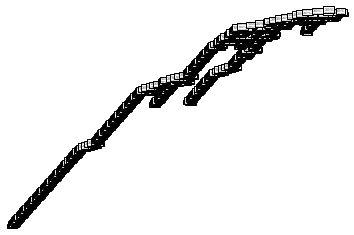

In [24]:
kf = KFold()
model = tree.DecisionTreeClassifier()

k_train_losses = list()
k_train_scores = list()
k_train_aucs = list()

k_val_losses = list()
k_val_scores = list()
k_val_aucs = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(x_train, y_train)
    
    train_probas = model.predict_proba(x_train)[:,1]
    val_probas = model.predict_proba(x_val)[:,1]

    k_train_losses.append(log_loss(y_train, train_probas))
    k_train_scores.append(model.score(x_train, y_train))
    k_train_aucs.append(roc_auc_score(y_train, train_probas))
    
    k_val_losses.append(log_loss(y_val, val_probas))
    k_val_scores.append(model.score(x_val, y_val))
    k_val_aucs.append(roc_auc_score(y_val, val_probas))
    
    print('   TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        k_train_scores[-1],
        k_train_aucs[-1],
        k_train_losses[-1]))

    print('   VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        k_val_scores[-1],
        k_val_aucs[-1],
        k_val_losses[-1]))

print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
    np.mean(k_train_scores),
    np.mean(k_train_aucs),
    np.mean(k_train_losses)))

print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
    np.mean(k_val_scores),
    np.mean(k_val_aucs),
    np.mean(k_val_losses)))

tree.plot_tree(model)
plt.show()

depth: 1.000000   score: 0.643750   auc: 0.761513
depth: 2.610157   score: 0.661667   auc: 0.819245
depth: 6.812921   score: 0.734583   auc: 0.845244
depth: 17.782794   score: 0.776667   auc: 0.866404
depth: 46.415888   score: 0.791667   auc: 0.873214
depth: 121.152766   score: 0.791250   auc: 0.876837
depth: 316.227766   score: 0.786667   auc: 0.873750
depth: 825.404185   score: 0.787083   auc: 0.866581
depth: 2154.434690   score: 0.774167   auc: 0.872345
depth: 5623.413252   score: 0.790000   auc: 0.873649
depth: 14677.992676   score: 0.785000   auc: 0.869476
depth: 38311.868496   score: 0.790000   auc: 0.871507
depth: 100000.000000   score: 0.780417   auc: 0.867265
depth: 261015.721568   score: 0.792917   auc: 0.873249
depth: 681292.069058   score: 0.783750   auc: 0.867196
depth: 1778279.410039   score: 0.784167   auc: 0.868039
depth: 4641588.833613   score: 0.785833   auc: 0.868507
depth: 12115276.586286   score: 0.788333   auc: 0.872329
depth: 31622776.601684   score: 0.779167   a

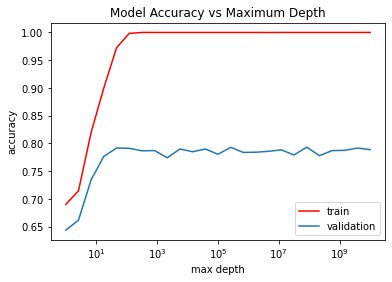

In [43]:
# find best depth
train_scores = list()
train_aucs = list()

val_scores = list()
val_aucs = list()

best_depth = 1
best_score = 0

kf = KFold(shuffle=True)
for d in np.logspace(0, 10, 25):
    model = RandomForestClassifier(max_depth=d)
    
    k_train_scores = list()
    k_train_aucs = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(x_train, y_train)
        
        train_probas = model.predict_proba(x_train)[:,1]
        val_probas = model.predict_proba(x_val)[:,1]
                
        k_train_scores.append(model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        
        k_val_scores.append(model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))

    if np.mean(k_val_scores) > best_score:
        best_depth = d
        best_score = np.mean(k_val_scores)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    
    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    
    print('depth: {:2f}   score: {:5f}   auc: {:5f}'.format(
        d,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs)))

print('best depth:', best_depth)

# plot accuracy
plt.title('Model Accuracy vs Maximum Depth')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.plot(np.logspace(0, 10, 25), train_scores, c='r', label='train')
plt.plot(np.logspace(0, 10, 25), val_scores, label='validation')
plt.xscale('log')
plt.legend()
plt.show()

leaves: 10.000000   score: 0.764583   auc: 0.859142
leaves: 13.335214   score: 0.780417   auc: 0.859106
leaves: 17.782794   score: 0.769583   auc: 0.857200
leaves: 23.713737   score: 0.782500   auc: 0.865271
leaves: 31.622777   score: 0.773750   auc: 0.861724
leaves: 42.169650   score: 0.783333   auc: 0.866246
leaves: 56.234133   score: 0.792083   auc: 0.870039
leaves: 74.989421   score: 0.795833   auc: 0.874228
leaves: 100.000000   score: 0.800417   auc: 0.872481
leaves: 133.352143   score: 0.794583   auc: 0.873886
leaves: 177.827941   score: 0.797917   auc: 0.876149
leaves: 237.137371   score: 0.798750   auc: 0.880829
leaves: 316.227766   score: 0.790000   auc: 0.877296
leaves: 421.696503   score: 0.805000   auc: 0.881182
leaves: 562.341325   score: 0.787500   auc: 0.870716
leaves: 749.894209   score: 0.792917   auc: 0.871069
leaves: 1000.000000   score: 0.788333   auc: 0.870885
leaves: 1333.521432   score: 0.781250   auc: 0.869086
leaves: 1778.279410   score: 0.780000   auc: 0.86530

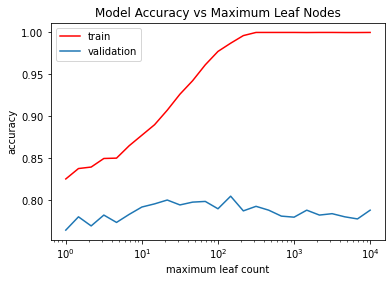

In [35]:
# find best number of leaves
train_scores = list()
train_aucs = list()

val_scores = list()
val_aucs = list()

best_max_leaves = 1
best_score = 0

kf = KFold(shuffle=True)
for n in np.logspace(1, 4, 25):
    model = RandomForestClassifier(max_leaf_nodes=int(n))
    
    k_train_scores = list()
    k_train_aucs = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(x_train, y_train)
        
        train_probas = model.predict_proba(x_train)[:,1]
        val_probas = model.predict_proba(x_val)[:,1]
                
        k_train_scores.append(model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        
        k_val_scores.append(model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))

    if np.mean(k_val_scores) > best_score:
        best_max_leaves = n
        best_score = np.mean(k_val_scores)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    
    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    
    print('leaves: {:2f}   score: {:5f}   auc: {:5f}'.format(
        n,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs)))

print('best depth:', best_depth)

# plot accuracy
plt.title('Model Accuracy vs Maximum Leaf Nodes')
plt.xlabel('maximum leaf count')
plt.ylabel('accuracy')
plt.plot(np.logspace(1, 4, 25), train_scores, c='r', label='train')
plt.plot(np.logspace(1, 4, 25), val_scores, label='validation')
plt.xscale('log')
plt.legend()
plt.show()

estimators: 1.000000   score: 0.677500   auc: 0.676481
estimators: 1.000000   score: 0.677917   auc: 0.677725
estimators: 1.000000   score: 0.674167   auc: 0.674361
estimators: 2.000000   score: 0.672083   auc: 0.721951
estimators: 3.000000   score: 0.701250   auc: 0.750349
estimators: 4.000000   score: 0.715833   auc: 0.775735
estimators: 5.000000   score: 0.712917   auc: 0.780488
estimators: 7.000000   score: 0.745833   auc: 0.812294
estimators: 10.000000   score: 0.753333   auc: 0.827816
estimators: 13.000000   score: 0.752083   auc: 0.836176
estimators: 17.000000   score: 0.772500   auc: 0.850722
estimators: 23.000000   score: 0.769167   auc: 0.847285
estimators: 31.000000   score: 0.772500   auc: 0.859855
estimators: 42.000000   score: 0.779583   auc: 0.862941
estimators: 56.000000   score: 0.774583   auc: 0.860318
estimators: 74.000000   score: 0.781250   auc: 0.871819
estimators: 100.000000   score: 0.778333   auc: 0.869617
estimators: 133.000000   score: 0.788333   auc: 0.87078

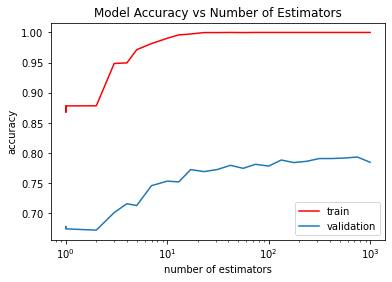

In [42]:
# find best number of estimators
train_scores = list()
train_aucs = list()

val_scores = list()
val_aucs = list()

best_num_estimators = 1
best_score = 0

kf = KFold(shuffle=True)
for n in [int(i) for i in np.logspace(0, 3, 25)]:
    model = RandomForestClassifier(n_estimators=n)
    
    k_train_scores = list()
    k_train_aucs = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(x_train, y_train)
        
        train_probas = model.predict_proba(x_train)[:,1]
        val_probas = model.predict_proba(x_val)[:,1]
                
        k_train_scores.append(model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        
        k_val_scores.append(model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))

    if np.mean(k_val_scores) > best_score:
        best_num_estimators = n
        best_score = np.mean(k_val_scores)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    
    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    
    print('estimators: {:1f}   score: {:5f}   auc: {:5f}'.format(
        n,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs)))

print('best estimators:', best_num_estimators)

# plot accuracy
plt.title('Model Accuracy vs Number of Estimators')
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.plot([int(i) for i in np.logspace(0, 3, 25)], train_scores, c='r', label='train')
plt.plot([int(i) for i in np.logspace(0, 3, 25)], val_scores, label='validation')
plt.xscale('log')
plt.legend()
plt.show()

In [46]:
parameters = {
    'n_estimators': [int(i) for i in np.logspace(0, 3, 25)],
    'max_depth': [int(i) for i in np.logspace(0, 10, 25)],
    'max_leaf_nodes': [int(i) for i in np.logspace(1, 4, 25)]
}

rfc = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=50)
best = rfc.fit(X, y)


pd.DataFrame(best.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_leaf_nodes,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.516970,0.078142,0.033700,0.000951,133,74,2154,"{'n_estimators': 133, 'max_leaf_nodes': 74, 'm...",0.785417,0.793750,0.768750,0.756250,0.814583,0.783750,0.020173,9
1,0.365622,0.005070,0.007580,0.000799,23,177,121,"{'n_estimators': 23, 'max_leaf_nodes': 177, 'm...",0.814583,0.785417,0.766667,0.733333,0.804167,0.780833,0.028849,11
2,0.111997,0.006661,0.003191,0.000406,10,74,261015,"{'n_estimators': 10, 'max_leaf_nodes': 74, 'ma...",0.793750,0.733333,0.710417,0.745833,0.766667,0.750000,0.028474,30
3,0.076789,0.002590,0.007380,0.001833,42,5623,1,"{'n_estimators': 42, 'max_leaf_nodes': 5623, '...",0.547917,0.625000,0.622917,0.625000,0.679167,0.620000,0.041845,48
4,0.058643,0.002130,0.002400,0.000483,2,3162,100000,"{'n_estimators': 2, 'max_leaf_nodes': 3162, 'm...",0.741667,0.629167,0.589583,0.631250,0.652083,0.648750,0.050666,44
5,2.353892,0.049307,0.035175,0.001628,100,10000,121,"{'n_estimators': 100, 'max_leaf_nodes': 10000,...",0.808333,0.779167,0.772917,0.772917,0.804167,0.787500,0.015534,5
6,15.724759,0.232795,0.218210,0.006097,562,2371,4641588,"{'n_estimators': 562, 'max_leaf_nodes': 2371, ...",0.806250,0.772917,0.795833,0.760417,0.802083,0.787500,0.017776,5
7,1.027979,0.035712,0.090957,0.001458,562,5623,1,"{'n_estimators': 562, 'max_leaf_nodes': 5623, ...",0.777083,0.772917,0.710417,0.756250,0.800000,0.763333,0.029919,24
8,0.670344,0.015385,0.012560,0.001190,31,421,825,"{'n_estimators': 31, 'max_leaf_nodes': 421, 'm...",0.800000,0.772917,0.760417,0.750000,0.787500,0.774167,0.017999,18
9,0.044476,0.002073,0.001602,0.000493,2,421,215443469,"{'n_estimators': 2, 'max_leaf_nodes': 421, 'ma...",0.702083,0.670833,0.662500,0.658333,0.660417,0.670833,0.016191,39


In [47]:
parameters = {
    'n_estimators': [int(i) for i in np.logspace(0, 3, 25)],
    # 'max_depth': [int(i) for i in np.logspace(0, 10, 25)],
    'max_leaf_nodes': [int(i) for i in np.logspace(1, 4, 25)]
}

rfc = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=50)
best = rfc.fit(X, y)


pd.DataFrame(best.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031916,0.005048,0.001794,0.000398,1,7498,"{'n_estimators': 1, 'max_leaf_nodes': 7498}",0.714583,0.616667,0.656250,0.652083,0.670833,0.662083,0.031716,45
1,0.327523,0.014278,0.006776,0.000745,23,133,"{'n_estimators': 23, 'max_leaf_nodes': 133}",0.812500,0.764583,0.754167,0.764583,0.789583,0.777083,0.021205,16
2,0.160560,0.036406,0.003591,0.001198,5,1778,"{'n_estimators': 5, 'max_leaf_nodes': 1778}",0.729167,0.693750,0.670833,0.693750,0.704167,0.698333,0.018884,41
3,1.208300,0.101814,0.017175,0.000406,42,5623,"{'n_estimators': 42, 'max_leaf_nodes': 5623}",0.785417,0.766667,0.764583,0.733333,0.779167,0.765833,0.017999,21
4,0.084938,0.002992,0.002336,0.000681,3,10000,"{'n_estimators': 3, 'max_leaf_nodes': 10000}",0.710417,0.672917,0.654167,0.689583,0.702083,0.685833,0.020259,43
5,0.677978,0.045590,0.010774,0.001470,23,5623,"{'n_estimators': 23, 'max_leaf_nodes': 5623}",0.791667,0.775000,0.716667,0.760417,0.783333,0.765417,0.026471,22
6,0.137641,0.004227,0.003191,0.000745,5,4216,"{'n_estimators': 5, 'max_leaf_nodes': 4216}",0.700000,0.739583,0.704167,0.718750,0.687500,0.710000,0.017844,39
7,0.976967,0.020233,0.024458,0.002360,100,56,"{'n_estimators': 100, 'max_leaf_nodes': 56}",0.804167,0.791667,0.754167,0.747917,0.802083,0.780000,0.024102,14
8,0.016361,0.001503,0.002189,0.000966,4,10,"{'n_estimators': 4, 'max_leaf_nodes': 10}",0.606250,0.564583,0.600000,0.581250,0.608333,0.592083,0.016739,50
9,0.136361,0.005858,0.003917,0.001151,5,1000,"{'n_estimators': 5, 'max_leaf_nodes': 1000}",0.722917,0.695833,0.702083,0.722917,0.733333,0.715417,0.014105,38


In [59]:
kf = KFold(shuffle=True)
model = RandomForestClassifier(max_leaf_nodes=600)

k_train_losses = list()
k_train_scores = list()
k_train_aucs = list()

k_val_losses = list()
k_val_scores = list()
k_val_aucs = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(x_train, y_train)
    
    train_probas = model.predict_proba(x_train)[:,1]
    val_probas = model.predict_proba(x_val)[:,1]

    k_train_losses.append(log_loss(y_train, train_probas))
    k_train_scores.append(model.score(x_train, y_train))
    k_train_aucs.append(roc_auc_score(y_train, train_probas))
    
    k_val_losses.append(log_loss(y_val, val_probas))
    k_val_scores.append(model.score(x_val, y_val))
    k_val_aucs.append(roc_auc_score(y_val, val_probas))
    
    print('   TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        k_train_scores[-1],
        k_train_aucs[-1],
        k_train_losses[-1]))

    print('   VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        k_val_scores[-1],
        k_val_aucs[-1],
        k_val_losses[-1]))

print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
    np.mean(k_train_scores),
    np.mean(k_train_aucs),
    np.mean(k_train_losses)))

print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
    np.mean(k_val_scores),
    np.mean(k_val_aucs),
    np.mean(k_val_losses)))


   TRAIN -- score: 0.997917   auc: 0.999822   loss: 0.159861
   VALID -- score: 0.804167   auc: 0.874826   loss: 0.476400
   TRAIN -- score: 0.997917   auc: 0.999973   loss: 0.153043
   VALID -- score: 0.797917   auc: 0.871830   loss: 0.465388
   TRAIN -- score: 0.998437   auc: 0.999980   loss: 0.151009
   VALID -- score: 0.783333   auc: 0.856992   loss: 0.487946
   TRAIN -- score: 0.996354   auc: 0.999937   loss: 0.156958
   VALID -- score: 0.808333   auc: 0.890050   loss: 0.444357
   TRAIN -- score: 0.997917   auc: 0.999952   loss: 0.154605
   VALID -- score: 0.797917   auc: 0.874182   loss: 0.469402
TRAIN -- score: 0.997708   auc: 0.999933   loss: 0.155095
VALID -- score: 0.798333   auc: 0.873576   loss: 0.468699


In [60]:
np.std([0.804167, 0.797917, 0.783333, 0.808333, 0.797917])

0.008477991120542656